# PHÂN TÍCH CHẤT LƯỢNG RƯỢU ĐỎ

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

## Giới thiệu chung

## Bảng phân công công việc

## Phát biểu bài toán

## Giới thiệu về dữ liệu

## Import thư viện

In [1]:
library(dplyr)
library(tidyr)
library(car)
library(readxl)
library(mice)
library(VIM)
library(grid)
library(ggplot2)
library(cowplot)
library(missMDA)
library(FactoMineR)
library(TidyDensity)
library(MASS)
library(leaps)
library(lmtest)
library(Metrics)
library(MLmetrics)
library(pls)
library(gridExtra)
# library(caret)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



== Welcome to TidyDensity ===========================================================================
If you find this package useful, please leave a star: 
   https://github.com/spsanderson/TidyDensity'

If you enco

## Hàm phụ trợ

In [2]:
response_variable = 1 

# Hàm tiền xử lý dữ liệu với box-cox
bc_transform <- function(df) {
    col.names <- names(df)

    transformed_df <- df
    
    for (name in names(df))
    {
        col.name <- name

        print(col.name)

        # Rút trích biến phản hồi
        response_variable <- df[[col.name]]
        
        if (!is.numeric(response_variable)) {
            print(col.name)
            stop("The column to be transformed must be numeric.")
        }
        
        if (any(response_variable <= 0)) {
            # Shift the values to be positive
            shift_value <- abs(min(response_variable)) + 1
            response_variable <- response_variable + shift_value
        }
        
        # Áp dụng box-cox transform để tìm lambda tối ưu
        boxcox_result <- boxcox(lm(response_variable ~ 1), plotit = FALSE)
        optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
        print(paste("Optimal lambda:", optimal_lambda))
        
        # Sử dụng lambda tối ưu để biến đổi dữ liệu
        if (optimal_lambda == 0) {
            transformed_response <- log(response_variable)
        } else {
            transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
        }
        
        # Gán biến đã được biến đổi
        transformed_df[[col.name]] <- transformed_response
    }
    
    return(transformed_df)
}

indicator <- function(model, y_pred, y_true) {
     adj.r.sq <- summary(model)$adj.r.squared
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("Adjusted R-squared: ", round(adj.r.sq, 4)))
     print(paste0("MSE: ", round(mse, 4)))
     print(paste0("RMSE: ", round(rmse, 4)))
     print(paste0("MAE: ", round(mae, 4)))
}


metrics <- function(y_pred, y_true){
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("MSE: ", round(mse, 6)))
     print(paste0("RMSE: ", round(rmse, 6)))
     print(paste0("MAE: ", round(mae, 6)))
     corPredAct <- cor(y_pred, y_true)
     print(paste0("Correlation: ", round(corPredAct, 6)))
     print(paste0("R^2 between y_pred & y_true: ", round(corPredAct^2, 6)))
}

CheckNormal <- function(model) {
     hist(model$residuals, breaks = 30)
     shaptest <- shapiro.test(model$residuals)
     print(shaptest)
     if (shaptest$p.value <= 0.05) {
          print("H0 rejected: the residuals are NOT distributed normally")
     } else {
          print("H0 failed to reject: the residuals ARE distributed normally")
     }
}

CheckHomos <- function(model){
     plot(model$fitted.values, model$residuals)
     abline(h = 0, col = "red")
     BP <- bptest(model)
     print(BP)
     if (BP$p.value <= 0.05) {
          print("H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)")
     } else {
          print("H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)")
     }
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data = read.table("../../data/part2/wine+quality/winequality-red.csv", header=TRUE, sep=";", stringsAsFactors = FALSE)
str(raw_data)

'data.frame':	1599 obs. of  12 variables:
 $ fixed.acidity       : num  7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 7.5 ...
 $ volatile.acidity    : num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric.acid         : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual.sugar      : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ chlorides           : num  0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.071 ...
 $ free.sulfur.dioxide : num  11 25 15 17 11 13 15 15 9 17 ...
 $ total.sulfur.dioxide: num  34 67 54 60 34 40 59 21 18 102 ...
 $ density             : num  0.998 0.997 0.997 0.998 0.998 ...
 $ pH                  : num  3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.35 ...
 $ sulphates           : num  0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.8 ...
 $ alcohol             : num  9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 10.5 ...
 $ quality             : int  5 5 5 6 5 5 5 7 7 5 ...


## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [4]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 4898 dòng và 12 cột
dim(raw_data)

[1] 1599   12

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [5]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- (raw_data[duplicated(raw_data), ])
length(duplicates)

[1] 12

In [6]:
clean_data <- unique(raw_data)

In [7]:
duplicates <- clean_data[duplicated(clean_data), ]
if (nrow(duplicates) == 0) {
  print("No duplicates found. Data is clean.")
} else {
  print("Duplicates still exist:")
  print(duplicates)
}

dim(raw_data)
dim(clean_data)

[1] "No duplicates found. Data is clean."


[1] 1599   12

[1] 1359   12

### Mỗi cột mang ý nghĩa gì?

In [8]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

'data.frame':	1599 obs. of  12 variables:
 $ fixed.acidity       : num  7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 7.5 ...
 $ volatile.acidity    : num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric.acid         : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual.sugar      : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ chlorides           : num  0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.071 ...
 $ free.sulfur.dioxide : num  11 25 15 17 11 13 15 15 9 17 ...
 $ total.sulfur.dioxide: num  34 67 54 60 34 40 59 21 18 102 ...
 $ density             : num  0.998 0.997 0.997 0.998 0.998 ...
 $ pH                  : num  3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.35 ...
 $ sulphates           : num  0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.8 ...
 $ alcohol             : num  9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 10.5 ...
 $ quality             : int  5 5 5 6 5 5 5 7 7 5 ...


Dưới đây là mô tả chi tiết về các đặc trưng trong bộ dữ liệu này:

| Tên biến             | Vai trò   | Kiểu     | Mô tả                                             | Đơn vị | Giá trị bị thiếu |
| -------------------- | --------- | -------- | ------------------------------------------------- | ------ | ---------------- |
| fixed_acidity        | Đặc trưng | Liên tục | Độ axit cố định (hầu hết là axit tartaric)        | g/dm³  | Không            |
| volatile_acidity     | Đặc trưng | Liên tục | Độ axit bay hơi (chủ yếu là axit acetic)          | g/dm³  | Không            |
| citric_acid          | Đặc trưng | Liên tục | Hàm lượng axit citric                             | g/dm³  | Không            |
| residual_sugar       | Đặc trưng | Liên tục | Lượng đường còn lại sau khi lên men               | g/dm³  | Không            |
| chlorides            | Đặc trưng | Liên tục | Lượng muối                                        | g/dm³  | Không            |
| free_sulfur_dioxide  | Đặc trưng | Liên tục | Lượng SO2 tự do                                   | mg/dm³ | Không            |
| total_sulfur_dioxide | Đặc trưng | Liên tục | Tổng lượng SO2                                    | mg/dm³ | Không            |
| density              | Đặc trưng | Liên tục | Mật độ của rượu                                   | g/cm³  | Không            |
| pH                   | Đặc trưng | Liên tục | Độ pH của rượu                                    |        | Không            |
| sulphates            | Đặc trưng | Liên tục | Lượng muối sunphat                                | g/dm³  | Không            |
| alcohol              | Đặc trưng | Liên tục | Phần trăm cồn trong rượu                          | %      | Không            |
| quality              | Mục tiêu  | Nguyên   | Điểm chất lượng của rượu (thang điểm từ 0 đến 10) |        | Không            |


### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

In [9]:
wine_quality_red <- raw_data

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [10]:
# Hàm tính toán tỷ lệ missing value
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Hàm tính toán trung vị (median)
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 25% (Q1)
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 75% (Q3)
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [11]:
# Lựa chọn những cột kiểu số
num_col_info_df <- as.data.frame(wine_quality_red) %>% select_if(is.numeric)

# Tổng hợp các kết quả thống kê
num_col_info_df <- as.data.frame(wine_quality_red) %>%
  select_if(is.numeric) %>%
  summarise(
    across(everything(), list(
      missing_ratio = ~ missing_ratio(.),
      min = ~ min(., na.rm = TRUE),
      lower_quartile = ~ lower_quartile(.),
      median = ~ median_custom(.),
      upper_quartile = ~ upper_quartile(.),
      max = ~ max(., na.rm = TRUE)
    ))
  )

num_col_info_df <- num_col_info_df %>%
  pivot_longer(
    cols = everything(),
    names_to = c("variable", ".value"),
    names_sep = "_"
  )

# In kết quả ra
print(num_col_info_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 36 rows [1, 3, 5, 7, 9, 11,
13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, ...].”


# A tibble: 12 × 7
   variable             missing   min lower median upper     max
   <chr>                  <dbl> <dbl> <dbl>  <dbl> <dbl>   <dbl>
 1 fixed.acidity              0 4.6     7.1    7.9   9.2  15.9  
 2 volatile.acidity           0 0.12    0.4    0.5   0.6   1.58 
 3 citric.acid                0 0       0.1    0.3   0.4   1    
 4 residual.sugar             0 0.9     1.9    2.2   2.6  15.5  
 5 chlorides                  0 0.012   0.1    0.1   0.1   0.611
 6 free.sulfur.dioxide        0 1       7     14    21    72    
 7 total.sulfur.dioxide       0 6      22     38    62   289    
 8 density                    0 0.990   1      1     1     1.00 
 9 pH                         0 2.74    3.2    3.3   3.4   4.01 
10 sulphates                  0 0.33    0.6    0.6   0.7   2    
11 alcohol                    0 8.4     9.5   10.2  11.1  14.9  
12 quality                    0 3       5      6     6     8    


In [12]:
print(summary(as.data.frame(wine_quality_red) %>% select_if(is.numeric)))

 fixed.acidity   volatile.acidity  citric.acid    residual.sugar  
 Min.   : 4.60   Min.   :0.1200   Min.   :0.000   Min.   : 0.900  
 1st Qu.: 7.10   1st Qu.:0.3900   1st Qu.:0.090   1st Qu.: 1.900  
 Median : 7.90   Median :0.5200   Median :0.260   Median : 2.200  
 Mean   : 8.32   Mean   :0.5278   Mean   :0.271   Mean   : 2.539  
 3rd Qu.: 9.20   3rd Qu.:0.6400   3rd Qu.:0.420   3rd Qu.: 2.600  
 Max.   :15.90   Max.   :1.5800   Max.   :1.000   Max.   :15.500  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.01200   Min.   : 1.00       Min.   :  6.00       Min.   :0.9901  
 1st Qu.:0.07000   1st Qu.: 7.00       1st Qu.: 22.00       1st Qu.:0.9956  
 Median :0.07900   Median :14.00       Median : 38.00       Median :0.9968  
 Mean   :0.08747   Mean   :15.87       Mean   : 46.47       Mean   :0.9967  
 3rd Qu.:0.09000   3rd Qu.:21.00       3rd Qu.: 62.00       3rd Qu.:0.9978  
 Max.   :0.61100   Max.   :72.00       Max.   :289.00       Max.   :1

### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

Không có cột nào có kiểu dữ liệu phân loại

## Quay lại bước phân tích xen kẽ với tiền xử lý dữ liệu

In [13]:
names(wine_quality_red)

[1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "free.sulfur.dioxide" 
 [7] "total.sulfur.dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "quality"

### Khảo sát chất lượng rượu đỏ

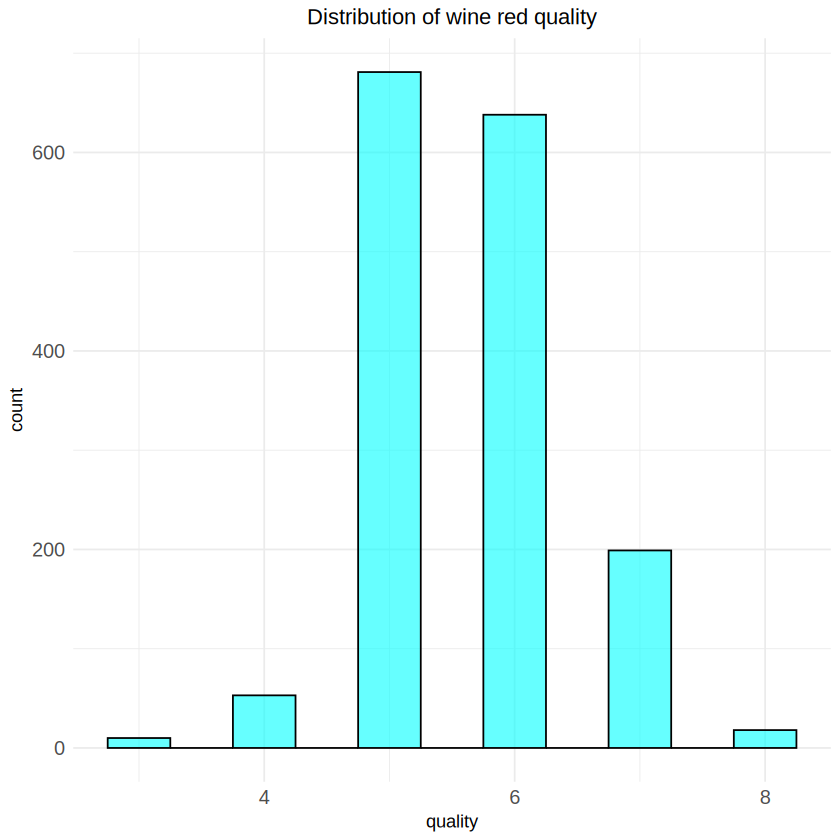

In [14]:
ggplot(wine_quality_red, aes(x = quality)) +
  geom_histogram(binwidth = 0.5, fill = "cyan", color = "black", alpha = 0.6) +
  theme_minimal() +
  ggtitle("Distribution of wine red quality") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

Nhận xét:
- Chất lượng rượu có phân phối đối xứng 
- Hầu hết chất lượng rượu đỏ nằm ở mức 5, 6
- Không có rượu đỏ nào đạt điểm tuyệt đối
- Chất lượng rượu đỏ tệ nhất có điểm số là 3

### Khảo sát tính chua (acidity) trong rượu đỏ

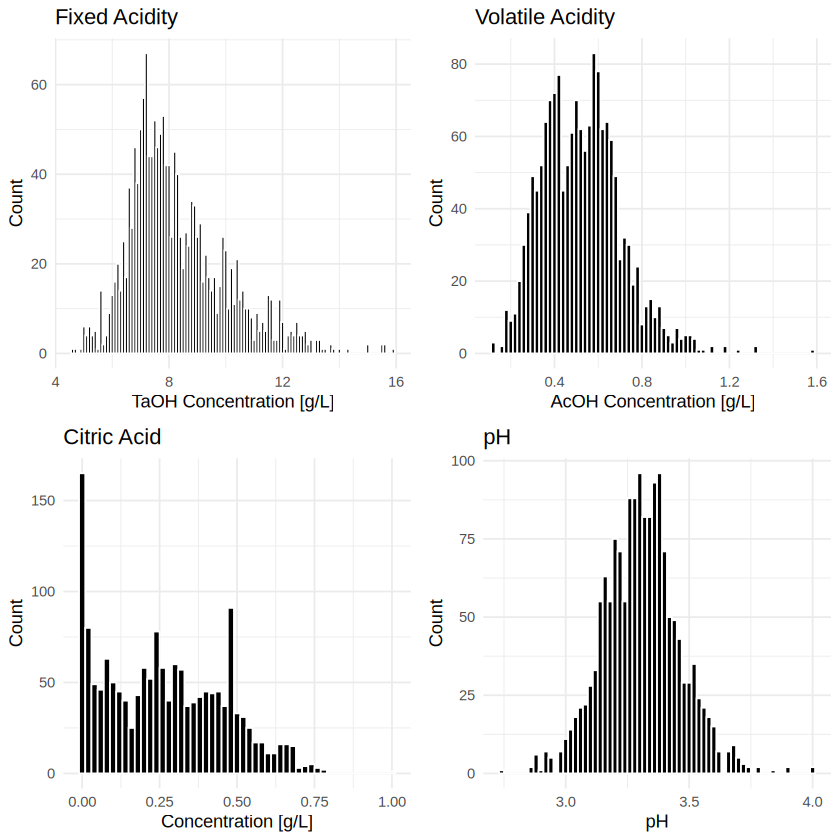

In [15]:
p1 <- ggplot(wine_quality_red, aes(x = fixed.acidity)) +
  geom_histogram(binwidth = 0.1, fill = "black", color = "white") +
  labs(title = "Fixed Acidity", x = "TaOH Concentration [g/L]", y = "Count") +
  theme_minimal()

p2 <- ggplot(wine_quality_red, aes(x = volatile.acidity)) +
  geom_histogram(binwidth = 0.02, fill = "black", color = "white") +
  labs(title = "Volatile Acidity", x = "AcOH Concentration [g/L]", y = "Count") +
  theme_minimal()

p3 <- ggplot(wine_quality_red, aes(x = citric.acid)) +
  geom_histogram(binwidth = 0.02, fill = "black", color = "white") +
  labs(title = "Citric Acid", x = "Concentration [g/L]", y = "Count") +
  theme_minimal()

p4 <- ggplot(wine_quality_red, aes(x = pH)) +
  geom_histogram(binwidth = 0.02, fill = "black", color = "white") +
  labs(title = "pH", x = "pH", y = "Count") +
  theme_minimal()

# Arrange the plots in a grid
grid.arrange(p1, p2, p3, p4, nrow = 2)

Nhận xét:
- Fixed và volatile acidity có phân phối (tương đối) bị lệch trái.
- Axit citric tạo thành phân bố biên vì một nhóm rượu vang dường như có nồng độ axit citric gần bằng 0.
- Histogram của pH tương đối đối xứng.
- Có một số ít các ngoại lại trong các biến này.

Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”


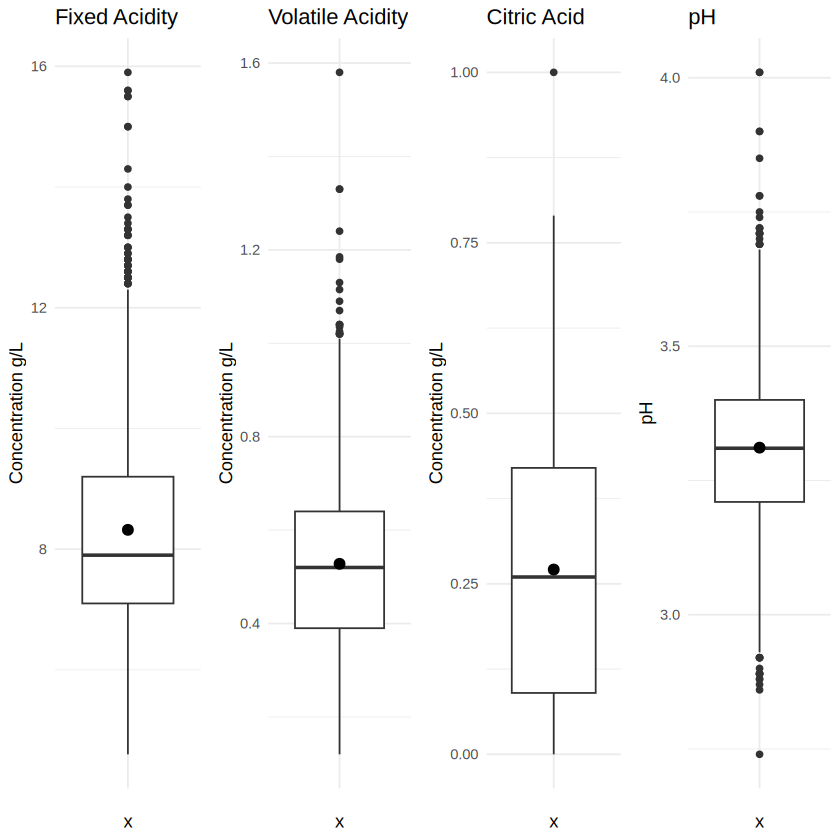

In [16]:
p1 <- ggplot(wine_quality_red, aes(x = "", y = fixed.acidity)) +
  geom_boxplot() +
  stat_summary(fun.y="mean") +
  labs(title = "Fixed Acidity", y = "Concentration g/L") +
  theme_minimal()

p2 <- ggplot(wine_quality_red, aes(x = "", y = volatile.acidity)) +
  geom_boxplot() +
  stat_summary(fun.y="mean") +
  labs(title = "Volatile Acidity", y = "Concentration g/L") +
  theme_minimal()

p3 <- ggplot(wine_quality_red, aes(x = "", y = citric.acid)) +
  geom_boxplot() +
  stat_summary(fun.y="mean") +
  labs(title = "Citric Acid", y = "Concentration g/L") +
  theme_minimal()

p4 <- ggplot(wine_quality_red, aes(x = "", y = pH)) +
  geom_boxplot() +
  stat_summary(fun.y="mean") +
  labs(title = "pH", y = "pH") +
  theme_minimal()

# Arrange the plots in a single row
grid.arrange(p1, p2, p3, p4, ncol = 4)

Nhận xét:
- Nhìn vào các thông số độ axit trong biểu đồ hộp cho thấy một hình ảnh tương tự. 
- Ta có thể thấy đuôi dương dài của nồng độ axit cố định (fixed acide) và dễ bay hơi (volatile acide) và phân phối hẹp hơn đối với axit citric và độ pH. 
- Giá trị trung bình của axit citric và pH gần giá trị median hơn là giá trị trung bình của axit cố định (fixed acide) và dễ bay hơi (volatile acide).

### Khảo sát hàm lượng lưu huỳnh trong rượu đỏ

Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


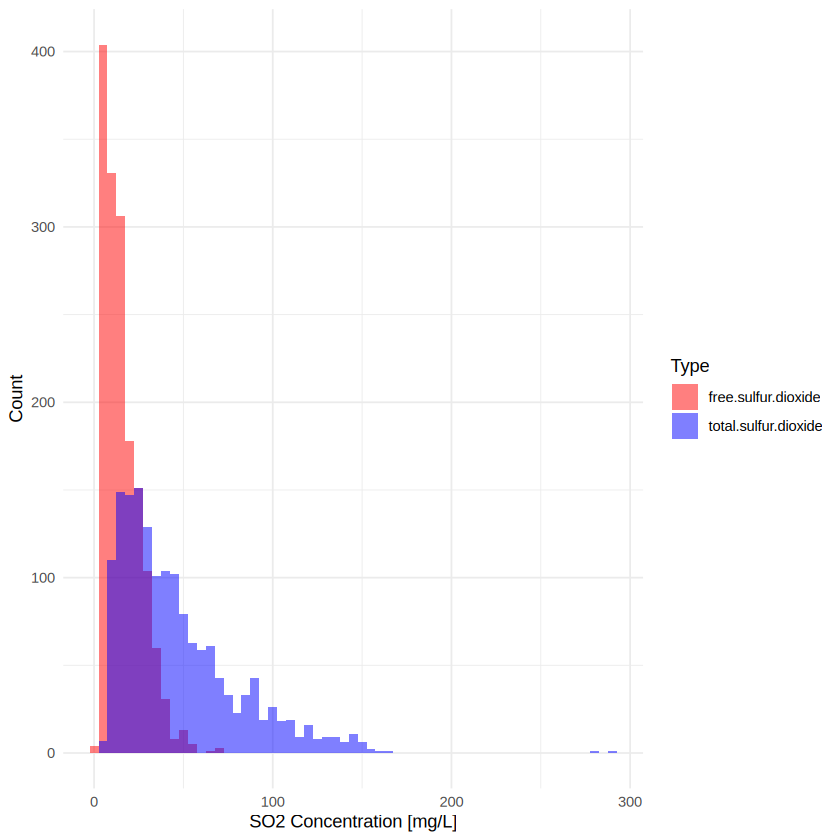

In [17]:
wine_data_long <- data.frame(
  value = c(wine_quality_red$free.sulfur.dioxide, wine_quality_red$total.sulfur.dioxide),
  type = rep(c("free.sulfur.dioxide", "total.sulfur.dioxide"), each = nrow(wine_quality_red))
)


ggplot(wine_data_long, aes(x = value, fill = type)) +
  geom_histogram(aes(y = ..count..), binwidth = 5, position = "identity", alpha = 0.5) +
  labs(x = "SO2 Concentration [mg/L]", y = "Count", fill = "Type") +
  scale_fill_manual(values = c("red", "blue")) +
  theme_minimal() +
  theme(legend.position = "right")

Nhận xét:
- Nồng độ lưu huỳnh dioxit tự do tập trung hẹp quanh mức 30 mg/L. Nồng độ lưu huỳnh dioxit tổng thể cho thấy một phân phối bị lệch trái.

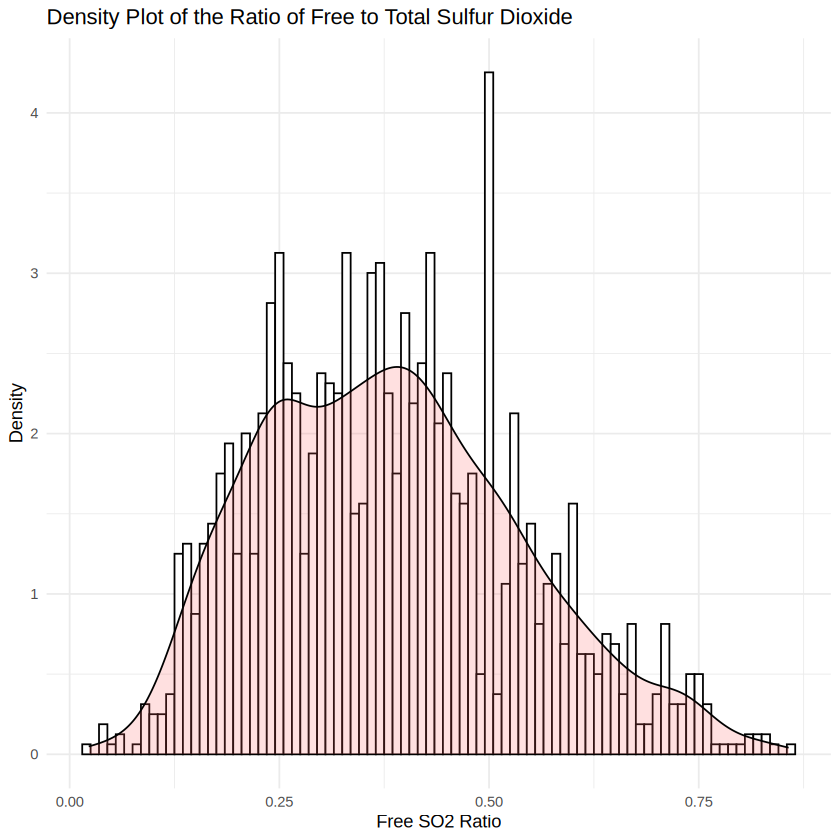

In [18]:
wine_combined <- wine_quality_red %>%
  mutate(ratio_sulfur_dioxide = free.sulfur.dioxide / total.sulfur.dioxide)

ggplot(wine_combined, aes(x = ratio_sulfur_dioxide)) +
  geom_histogram(aes(y = ..density..), binwidth = 0.01, fill = "white", color = "black") +
  geom_density(alpha = 0.2, fill = "#FF6666") +
  labs(title = "Density Plot of the Ratio of Free to Total Sulfur Dioxide",
       x = "Free SO2 Ratio",
       y = "Density") +
  theme_minimal()

Nhận xét:
- Khi vẽ biểu đồ tỷ lệ giữa lưu huỳnh dioxit tự do và lưu huỳnh dioxit tổng trong rượu vang, người ta có thể thấy rằng khoảng 30\% lưu huỳnh dioxit tổng xuất hiện ở dạng tự do. Sự phân bố bị lệch dương với một số loại rượu vang có tỷ lệ cao hơn đáng kể. Điểm đáng chú ý nữa là đỉnh xuất hiện chính xác ở mức 0,5.

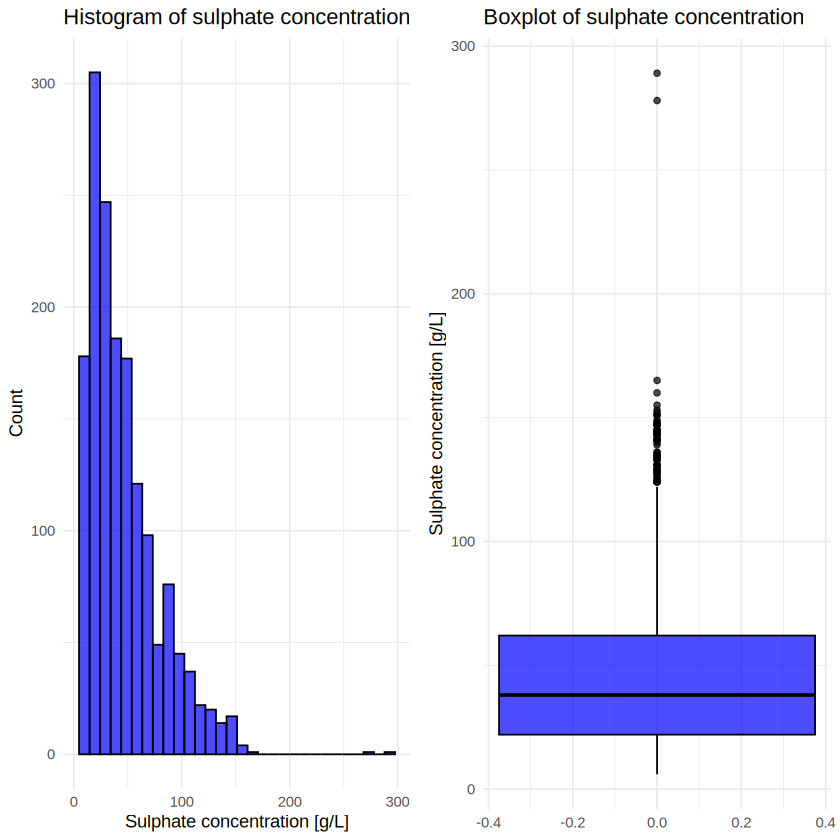

In [19]:
hist_plot <- ggplot(wine_quality_red, aes(x = total.sulfur.dioxide)) +
  geom_histogram(fill = "blue", color = "black", alpha = 0.7, bins = 30) +
  labs(title = "Histogram of sulphate concentration", x = "Sulphate concentration [g/L]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality_red, aes(y = total.sulfur.dioxide)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of sulphate concentration", y = "Sulphate concentration [g/L]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

Nhận xét:
- Hầu hết rượu vang đỏ có nồng độ sulfat khoảng 0,5 g/L. Có thể thấy ba nhóm ngoại lệ nhỏ trong biểu đồ.

### Khảo sát lượng đường còn lại sau khi lên men trong rượu đỏ

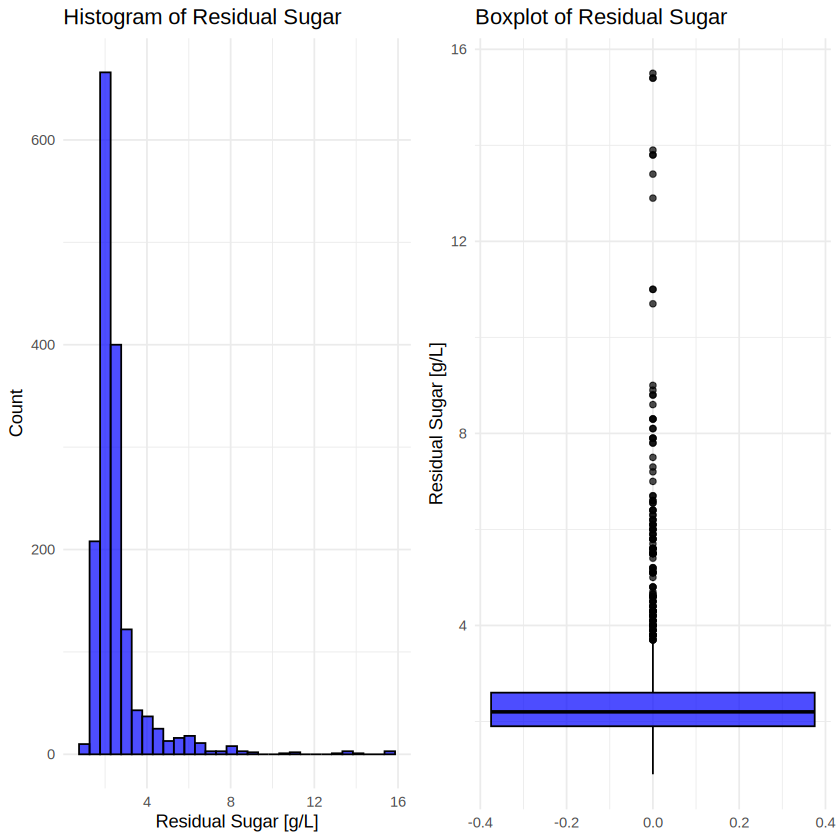

In [20]:
hist_plot <- ggplot(wine_quality_red, aes(x = residual.sugar)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of Residual Sugar", x = "Residual Sugar [g/L]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality_red, aes(y = residual.sugar)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of Residual Sugar", y = "Residual Sugar [g/L]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

Nhận xét:
- Nhìn chung, rượu vang đỏ trong tập dữ liệu có vẻ có nồng độ đường dư thấp gần bằng 0. 

### Khảo sát phần trăm cồn trong rượu đỏ

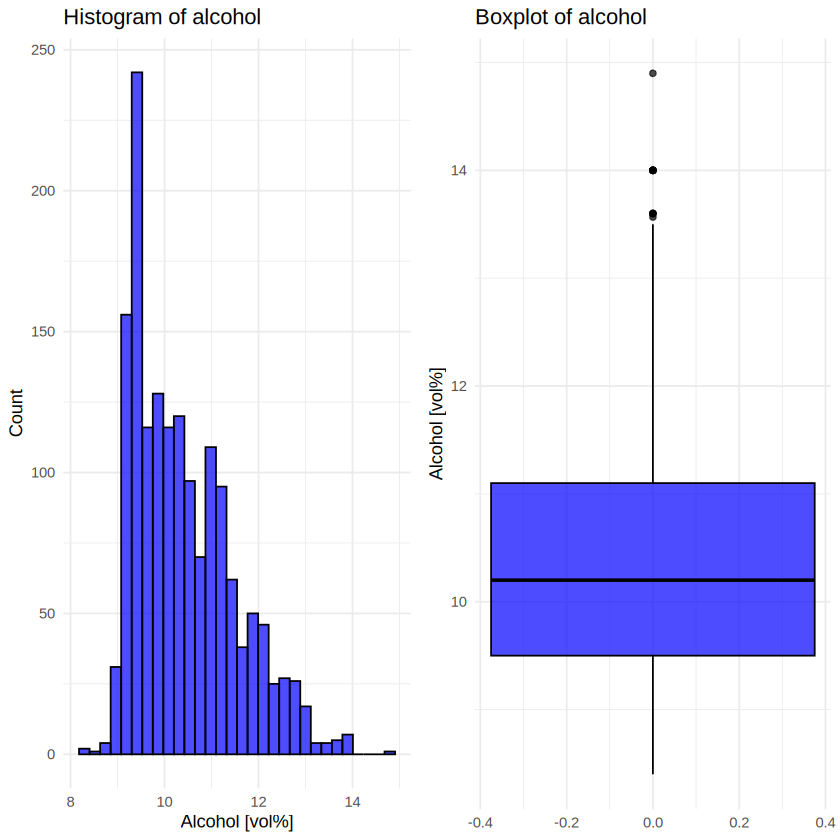

In [21]:
hist_plot <- ggplot(wine_quality_red, aes(x = alcohol)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of alcohol", x = "Alcohol [vol%]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality_red, aes(y = alcohol)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of alcohol", y = "Alcohol [vol%]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

Nhận xét:
- Hàm lượng cồn của rượu vang đỏ trong tập dữ liệu dao động từ 8 đến 15 vol\%. Giá trị trung bình nằm trong khoảng 10 vol. Phân phối khá rộng và cho thấy độ lệch dương.

### Khảo sát mật độ trong rượu đỏ

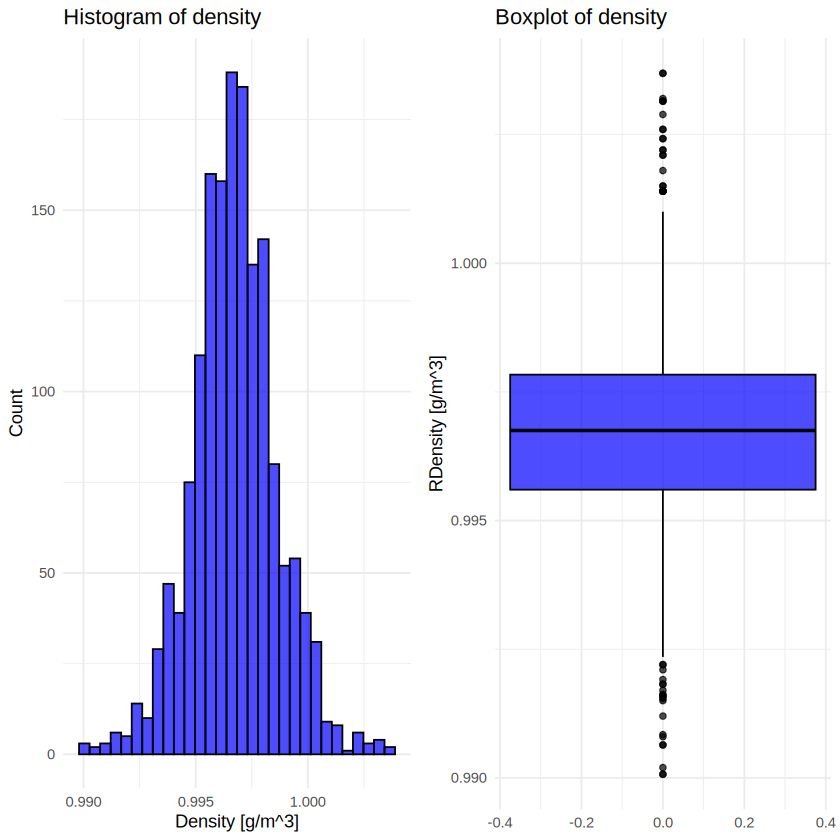

In [22]:
hist_plot <- ggplot(wine_quality_red, aes(x = density)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of density", x = "Density [g/m^3]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality_red, aes(y = density)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of density", y = "RDensity [g/m^3]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

Nhận xét:
- Tham số mật độ cho thấy sự phân bố rất hẹp với sự thay đổi thấp. Người ta có thể thấy một vài giá trị ngoại lệ trong khoảng 1,01 và 1,04 g/cm3 nhưng hầu hết các loại rượu vang có mật độ trong khoảng 0,99 và 1,00 g/cm3.

### Khảo sát lượng muối trong rượu đỏ

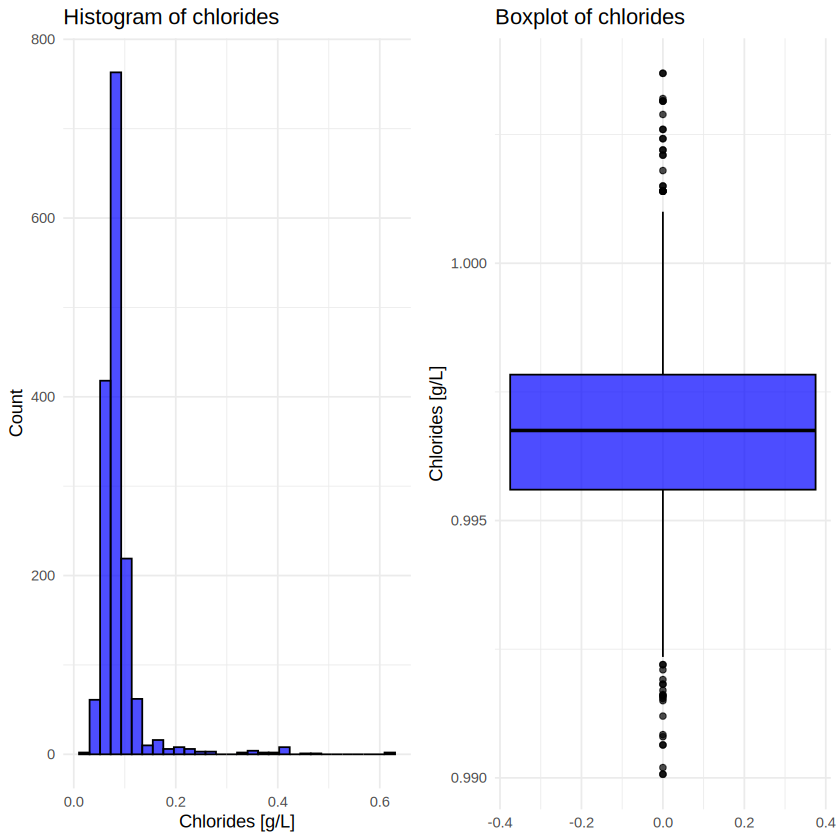

In [23]:
hist_plot <- ggplot(wine_quality_red, aes(x = chlorides)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of chlorides", x = "Chlorides [g/L]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality_red, aes(y = density)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of chlorides", y = "Chlorides [g/L]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

Nhận xét:
- Biểu đồ histogram của nồng độ clo cho thấy dữ liệu rượu đỏ tương dối cân bằng.

## Phân tích đa biến

### Phân tích ma trận tương quan

corrplot 0.92 loaded


Attaching package: ‘corrplot’


The following object is masked from ‘package:pls’:

    corrplot




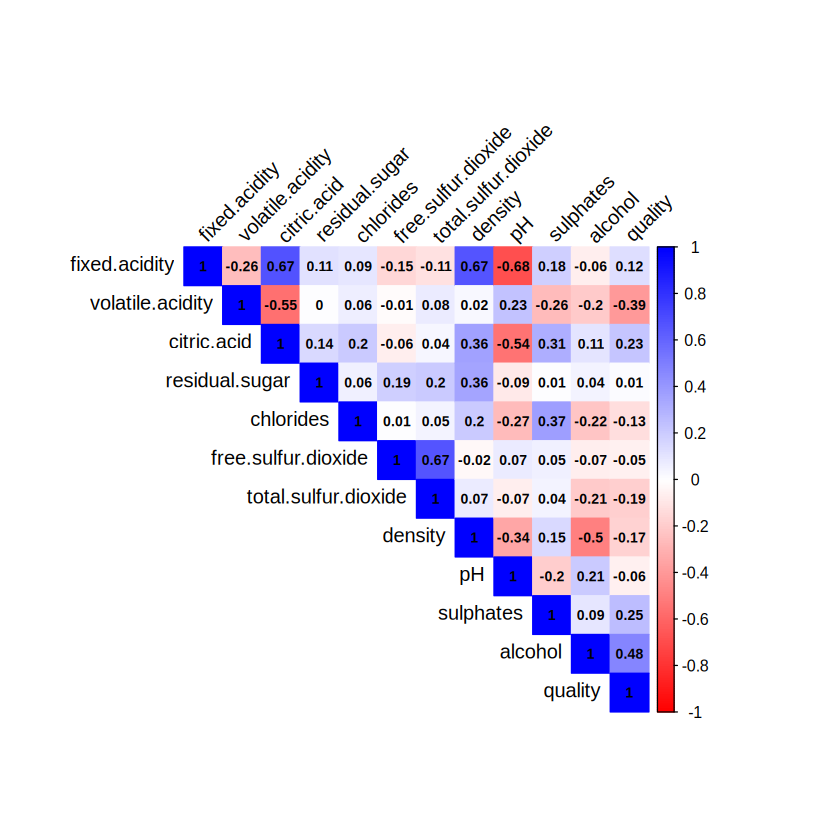

In [24]:
library(corrplot)

cor_matrix <- cor(wine_quality_red)

corrplot(cor_matrix, method = "color", type = "upper", 
         tl.col = "black", tl.srt = 45, addCoef.col = "black", number.cex = 0.7,
         col = colorRampPalette(c("red", "white", "blue"))(200))

In [25]:
threshold <- 0.3
positive_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if((cor_matrix[i, j]) > threshold) {
      positive_cor_pairs <- rbind(positive_cor_pairs, 
                              data.frame(Var1 = rownames(cor_matrix)[i], 
                                         Var2 = colnames(cor_matrix)[j], 
                                         value = cor_matrix[i, j]))
    }
  }
}

print(positive_cor_pairs)

                 Var1                 Var2     value
1       fixed.acidity          citric.acid 0.6717034
2       fixed.acidity              density 0.6680473
3         citric.acid              density 0.3649472
4         citric.acid            sulphates 0.3127700
5      residual.sugar              density 0.3552834
6           chlorides            sulphates 0.3712605
7 free.sulfur.dioxide total.sulfur.dioxide 0.6676665
8             alcohol              quality 0.4761663


Chọn ngưỡng là 0.3, ta thấy:
- Nồng độ cồn (alcohol) có ảnh hưởng (thuận) đến chất lượng rượu (chỉ số tương quan 0.476)
- Các biến `residual.sugar` và `density` có tương quan thuận thấp 0.35
- Biến fixed.acidity và citric.acid có tương quan dương mạnh, 0.671

In [26]:
threshold <- -0.3
negative_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if((cor_matrix[i, j]) < threshold) {
      negative_cor_pairs <- rbind(negative_cor_pairs, 
                              data.frame(Var1 = rownames(cor_matrix)[i], 
                                         Var2 = colnames(cor_matrix)[j], 
                                         value = cor_matrix[i, j]))
    }
  }
}

print(negative_cor_pairs)

              Var1        Var2      value
1    fixed.acidity          pH -0.6829782
2 volatile.acidity citric.acid -0.5524957
3 volatile.acidity     quality -0.3905578
4      citric.acid          pH -0.5419041
5          density          pH -0.3416993
6          density     alcohol -0.4961798


Chọn ngưỡng là -0.3, ta thấy:
- Mật độ trong rượu (`density`) có ảnh hưởng (nghịch) đến pH của rượu (chỉ số tương quan -0.34) và alcohol (-0.496)

## Khảo sát đa cộng tuyến

In [27]:
model <- lm(quality ~ ., data = wine_quality_red)
vif_values <- vif(model)
print(vif_values)

       fixed.acidity     volatile.acidity          citric.acid 
            7.767512             1.789390             3.128022 
      residual.sugar            chlorides  free.sulfur.dioxide 
            1.702588             1.481932             1.963019 
total.sulfur.dioxide              density                   pH 
            2.186813             6.343760             3.329732 
           sulphates              alcohol 
            1.429434             3.031160 


In [28]:
threshold <- 3
while (any(vif_values > threshold)) {
  highest_vif <- which.max(vif_values)
  variable_to_remove <- names(vif_values)[highest_vif]
  formula <- as.formula(paste("quality ~ . -", variable_to_remove))
  model <- update(model, formula)
  vif_values <- vif(model)
}

In [29]:
print(vif_values)
summary(model)

    volatile.acidity          citric.acid       residual.sugar 
            1.784963             2.780557             1.386375 
           chlorides  free.sulfur.dioxide total.sulfur.dioxide 
            1.401232             1.939209             2.069396 
             density                   pH            sulphates 
            2.430096             1.610775             1.396382 
             alcohol 
            2.136067 



Call:
lm(formula = quality ~ volatile.acidity + citric.acid + residual.sugar + 
    chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    density + pH + sulphates + alcohol, data = wine_quality_red)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.65461 -0.36856 -0.04552  0.45670  2.03464 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           6.1795700 13.4367180   0.460   0.6456    
volatile.acidity     -1.0777894  0.1209486  -8.911  < 2e-16 ***
citric.acid          -0.1353226  0.1387582  -0.975   0.3296    
residual.sugar        0.0101047  0.0135372   0.746   0.4555    
chlorides            -1.9684566  0.4076978  -4.828 1.51e-06 ***
free.sulfur.dioxide   0.0045916  0.0021580   2.128   0.0335 *  
total.sulfur.dioxide -0.0034272  0.0007089  -4.835 1.46e-06 ***
density              -1.5167406 13.3889717  -0.113   0.9098    
pH                   -0.5462340  0.1332577  -4.099 4.36e-05 ***
sulphates             0.8995900  

In [30]:
clean_df <- wine_quality_red[,names((vif_values))]
clean_df$quality <- wine_quality_red$quality
head(clean_df)

,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
2,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
3,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
4,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
5,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
6,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


In [31]:
wine_quality_red <- clean_df

## Khảo sát ngoại lai

In [32]:
# Khảo sát ngoại lai theo biến diff
diff_data <- wine_quality_red
outliers_index <- list()
extreme_outliers_index <- list()

for (i in 1:ncol(diff_data)) {
  # Tính toán Q1, Q3 và IQR
  Q1 = quantile(diff_data[, i], 0.25, na.rm = TRUE)
  Q3 = quantile(diff_data[, i], 0.75, na.rm = TRUE)
  IQR = Q3 - Q1

  # Xác định ngoại lai
  outliers_index_i = diff_data[, i] < (Q1 - 1.5 * IQR) | diff_data[, i] > (Q3 + 1.5 * IQR)
  # outliers_i = diff_data[diff_data[, i] < (Q1 - 1.5 * IQR) | diff_data[, i] > (Q3 + 1.5 * IQR), i]

  # Lưu trữ ngoại lai
  field_name = names(diff_data)[i]
  outliers_index[[field_name]] = which(outliers_index_i)

  # Xác định cực ngoại lai
  extreme_outliers_index_i = diff_data[, i] < (Q1 - 3 * IQR) | diff_data[, i] > (Q3 + 3 * IQR)
  extreme_outliers_index[[field_name]] = which(extreme_outliers_index_i)
}
# In kết quả theo từng biến ra màn hình
for (i in 1:ncol(diff_data)) {
  print(paste("Biến:", names(diff_data)[i]))
  print(paste("Số ngoại lai:", length(outliers_index[[names(diff_data)[i]]])))
  print(paste("Số cực ngoại lai:", length(extreme_outliers_index[[names(diff_data)[i]]])))
}

# Tìm tổng số quan trắc ngoại lai và cực ngoại lai thực sự
outliers = c()
extreme_outliners = c()
for (i in 1:ncol(diff_data)){
    outliers = c(outliers, outliers_index[[names(diff_data)[i]]])
    extreme_outliners = c(extreme_outliners, extreme_outliers_index[[names(diff_data)[i]]])
}

outliers = unique(outliers)
extreme_outliners = unique(extreme_outliners)
print(paste("Tổng số ngoại lai:", length(outliers)))
print(paste("Tổng số cực ngoại lai:", length(extreme_outliners)))

[1] "Biến: volatile.acidity"
[1] "Số ngoại lai: 19"
[1] "Số cực ngoại lai: 1"
[1] "Biến: citric.acid"
[1] "Số ngoại lai: 1"
[1] "Số cực ngoại lai: 0"
[1] "Biến: residual.sugar"
[1] "Số ngoại lai: 155"
[1] "Số cực ngoại lai: 88"
[1] "Biến: chlorides"
[1] "Số ngoại lai: 112"
[1] "Số cực ngoại lai: 67"
[1] "Biến: free.sulfur.dioxide"
[1] "Số ngoại lai: 30"
[1] "Số cực ngoại lai: 4"
[1] "Biến: total.sulfur.dioxide"
[1] "Số ngoại lai: 55"
[1] "Số cực ngoại lai: 2"
[1] "Biến: density"
[1] "Số ngoại lai: 45"
[1] "Số cực ngoại lai: 0"
[1] "Biến: pH"
[1] "Số ngoại lai: 35"
[1] "Số cực ngoại lai: 2"
[1] "Biến: sulphates"
[1] "Số ngoại lai: 59"
[1] "Số cực ngoại lai: 16"
[1] "Biến: alcohol"
[1] "Số ngoại lai: 13"
[1] "Số cực ngoại lai: 0"
[1] "Biến: quality"
[1] "Số ngoại lai: 28"
[1] "Số cực ngoại lai: 0"
[1] "Tổng số ngoại lai: 393"
[1] "Tổng số cực ngoại lai: 160"


Ta sử dụng IQR để tìm các điểm ngoại lai và cực ngoại lai:
- Tổng số ngoại lai: 393
- Tổng số cực ngoại lai: 160

Trong bài toán này, ta sẽ loại bỏ các điểm cực ngoại lai

In [33]:
cleaned_df <- wine_quality_red[-extreme_outliners, ]
dim(cleaned_df)
dim(wine_quality_red)

[1] 1439   11

[1] 1599   11

In [34]:
wine_quality_red <- cleaned_df

## Chuẩn hóa dữ liệu

In [35]:
wine_quality_red <- bc_transform(wine_quality_red)
head(wine_quality_red)

[1] "volatile.acidity"
[1] "Optimal lambda: -2"
[1] "citric.acid"
[1] "Optimal lambda: -2"
[1] "residual.sugar"
[1] "Optimal lambda: -2"
[1] "chlorides"
[1] "Optimal lambda: -2"
[1] "free.sulfur.dioxide"
[1] "Optimal lambda: -2"
[1] "total.sulfur.dioxide"
[1] "Optimal lambda: -2"
[1] "density"
[1] "Optimal lambda: -2"
[1] "pH"
[1] "Optimal lambda: -2"
[1] "sulphates"
[1] "Optimal lambda: -2"
[1] "alcohol"
[1] "Optimal lambda: -2"
[1] "quality"
[1] "Optimal lambda: -2"


,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.5204082,0.00000000,0.3614958,-86.06510,0.4958678,0.4995675,-0.002207281,0.4594159,-1.0943878,0.4943413,0.4800000
2,-0.1456612,0.00000000,0.4260355,-51.56164,0.4992000,0.4998886,-0.003215426,0.4511719,-0.5813149,0.4947938,0.4800000
3,-0.3656510,0.03772189,0.4054820,-58.57372,0.4977778,0.4998285,-0.003013554,0.4529527,-0.6834320,0.4947938,0.4800000
4,-5.8775510,0.29454306,0.3614958,-88.38889,0.4982699,0.4998611,-0.002006016,0.4499279,-0.9863258,0.4947938,0.4861111
5,-0.5204082,0.00000000,0.3614958,-86.06510,0.4958678,0.4995675,-0.002207281,0.4594159,-1.0943878,0.4943413,0.4800000
6,-0.6478421,0.00000000,0.3456790,-88.38889,0.4970414,0.4996875,-0.002207281,0.4594159,-1.0943878,0.4943413,0.4800000


## Phân chia tập dữ liệu

In [36]:
split_ratio <- 0.8
split_index <- floor(nrow(wine_quality_red) * split_ratio)

train = wine_quality_red[1:split_index,]
test = wine_quality_red[(split_index + 1):nrow(wine_quality_red),]

In [37]:
# số chiều tập train
dim(train)
rownames(train) <- 1:nrow(train)

[1] 1151   11

In [38]:
# số chiều tập test
dim(test)
rownames(test) <- 1:nrow(test)

[1] 288  11

In [39]:
# xem một số quan trắc của tập train
str(train)

'data.frame':	1151 obs. of  11 variables:
 $ volatile.acidity    : num  -0.52 -0.146 -0.366 -5.878 -0.52 ...
 $ citric.acid         : num  0 0 0.0377 0.2945 0 ...
 $ residual.sugar      : num  0.361 0.426 0.405 0.361 0.361 ...
 $ chlorides           : num  -86.1 -51.6 -58.6 -88.4 -86.1 ...
 $ free.sulfur.dioxide : num  0.496 0.499 0.498 0.498 0.496 ...
 $ total.sulfur.dioxide: num  0.5 0.5 0.5 0.5 0.5 ...
 $ density             : num  -0.00221 -0.00322 -0.00301 -0.00201 -0.00221 ...
 $ pH                  : num  0.459 0.451 0.453 0.45 0.459 ...
 $ sulphates           : num  -1.094 -0.581 -0.683 -0.986 -1.094 ...
 $ alcohol             : num  0.494 0.495 0.495 0.495 0.494 ...
 $ quality             : num  0.48 0.48 0.48 0.486 0.48 ...


## Mô hình hóa hồi quy tuyến tính đa biến

### Xây dựng mô hình đầy đủ

In [40]:
full.lm <- lm(quality ~ ., data = train)
print(summary(full.lm))


Call:
lm(formula = quality ~ ., data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.038957 -0.001818  0.000225  0.002779  0.009845 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -2.232e-01  1.153e-01  -1.935  0.05320 .  
volatile.acidity     -2.341e-04  5.452e-05  -4.293 1.91e-05 ***
citric.acid           7.504e-04  1.871e-03   0.401  0.68843    
residual.sugar        2.566e-03  2.804e-03   0.915  0.36024    
chlorides            -2.017e-06  9.282e-07  -2.173  0.02996 *  
free.sulfur.dioxide  -8.216e-04  6.039e-03  -0.136  0.89180    
total.sulfur.dioxide  1.801e-02  9.218e-02   0.195  0.84513    
density              -3.422e-01  1.073e-01  -3.189  0.00147 ** 
pH                   -1.594e-01  3.794e-02  -4.201 2.86e-05 ***
sulphates             2.641e-03  2.902e-04   9.101  < 2e-16 ***
alcohol               1.554e+00  1.999e-01   7.777 1.66e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’

### Lựa chọn mô hình tốt nhất

In [41]:
# Mô hình chặn dưới
model.lb <- lm(quality ~ 1, data = train)

In [42]:
# Mô hình chặn trên
model.up <- full.lm

In [43]:
step(full.lm, scope = list(lower = model.lb, upper = model.up), direction = "both", trace = FALSE)


Call:
lm(formula = quality ~ volatile.acidity + chlorides + density + 
    pH + sulphates + alcohol, data = train)

Coefficients:
     (Intercept)  volatile.acidity         chlorides           density  
      -2.489e-01        -2.356e-04        -2.089e-06        -2.798e-01  
              pH         sulphates           alcohol  
      -1.626e-01         2.639e-03         1.629e+00  


In [44]:
wqr_models <- regsubsets(quality ~ volatile.acidity + chlorides + density + pH + sulphates + alcohol, data = train)
summary.wqr <-summary(wqr_models)

In [45]:
# Lựa chọn mô hình tốt nhất từ reg subsets
summary.wqr$which

,(Intercept),volatile.acidity,chlorides,density,pH,sulphates,alcohol
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
2,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE
3,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE
4,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE
5,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE
6,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


Tiêu chí chọn mô hình tốt nhất 1: mô hình với $R^2$ lớn (tương ứng với MSE nhỏ)

In [46]:
summary.wqr$rsq

[1] 0.1694112 0.2293602 0.2535020 0.2640019 0.2724471 0.2756935

Tiêu chí chọn mô hình tốt nhất 2: mô hình với $R^2$ hiệu chỉnh lớn

In [47]:
# model with largest adjusted R^2
summary.wqr$adjr2

[1] 0.1686883 0.2280176 0.2515496 0.2614330 0.2692701 0.2718947

Tiêu chí chọn mô hình tốt nhất 3: mô hình với Mallow's Cp nhỏ

In [48]:
# model with smallest Mallow's Cp
summary.wqr$cp

[1] 164.86669  72.18077  36.05007  21.46614  10.12738   7.00000

#### Chọn mô hình tốt nhất dựa trên BIC

In [49]:
# Tiêu chí chọn mô hình tốt nhất 4: mô hình với BIC nhỏ
summary.wqr$bic

[1] -199.5523 -278.7296 -308.3156 -317.5715 -323.8067 -321.9055

In [50]:
best_model_index <- which.min(summary.wqr$bic)
best_model <- summary.wqr$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

     (Intercept) volatile.acidity        chlorides          density 
            TRUE             TRUE            FALSE             TRUE 
              pH        sulphates          alcohol 
            TRUE             TRUE             TRUE 


[1] "volatile.acidity" "density"          "pH"               "sulphates"       
[5] "alcohol"         


In [51]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("quality ~", paste(best_vars, collapse = " + "))
best_model_wqr <- lm(as.formula(formula_str), data=train)

In [52]:
# Tóm tắt mô hình
summary(best_model_wqr)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.039242 -0.001816  0.000235  0.002780  0.009180 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -2.579e-01  8.929e-02  -2.888 0.003952 ** 
volatile.acidity -2.447e-04  4.915e-05  -4.979 7.38e-07 ***
density          -3.156e-01  8.656e-02  -3.646 0.000279 ***
pH               -1.648e-01  3.290e-02  -5.008 6.36e-07 ***
sulphates         2.545e-03  2.811e-04   9.054  < 2e-16 ***
alcohol           1.649e+00  1.773e-01   9.300  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.004389 on 1145 degrees of freedom
Multiple R-squared:  0.2724,	Adjusted R-squared:  0.2693 
F-statistic: 85.75 on 5 and 1145 DF,  p-value: < 2.2e-16


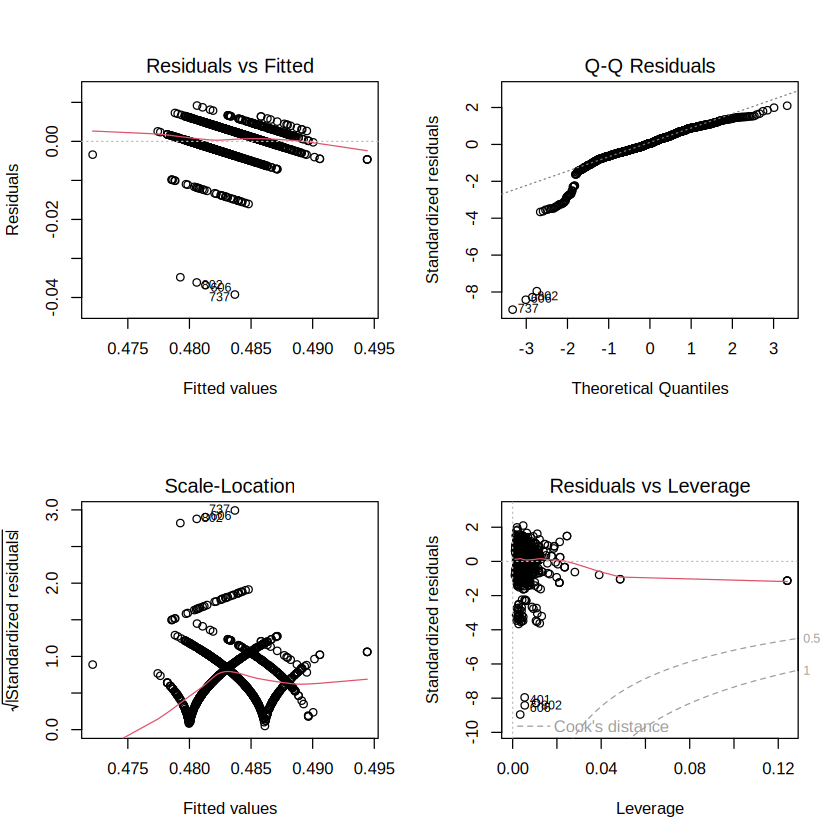

In [53]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_wqr)

#### Phân tích Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

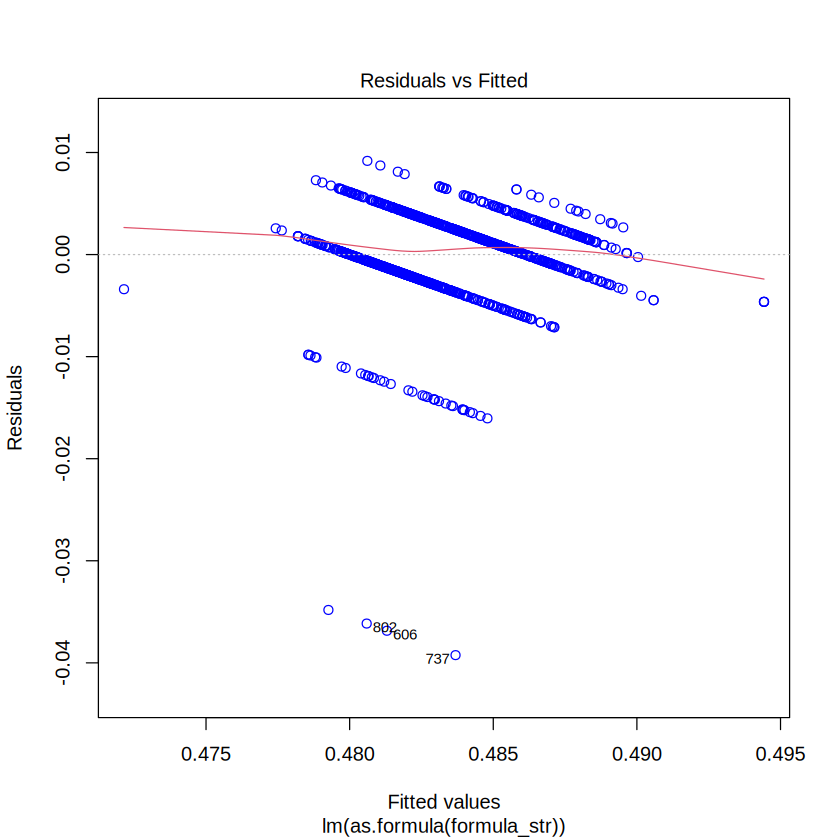

In [54]:
plot(best_model_wqr, which=1, col=c("blue")) # Residuals vs Fitted Plot

Dựa trên biểu đồ này, ta thấy đường cong màu đỏ có dáng chưa gần như một đường thẳng, và các phần tử trải dọc theo đường cong này một cách tương chưa đồng đều. Điều này chứng tỏ có quan hệ phi tuyến xuất hiện trong dữ liệu.

#### Phân tích Normal Q–Q (quantile-quantile) Plot

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.81862, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


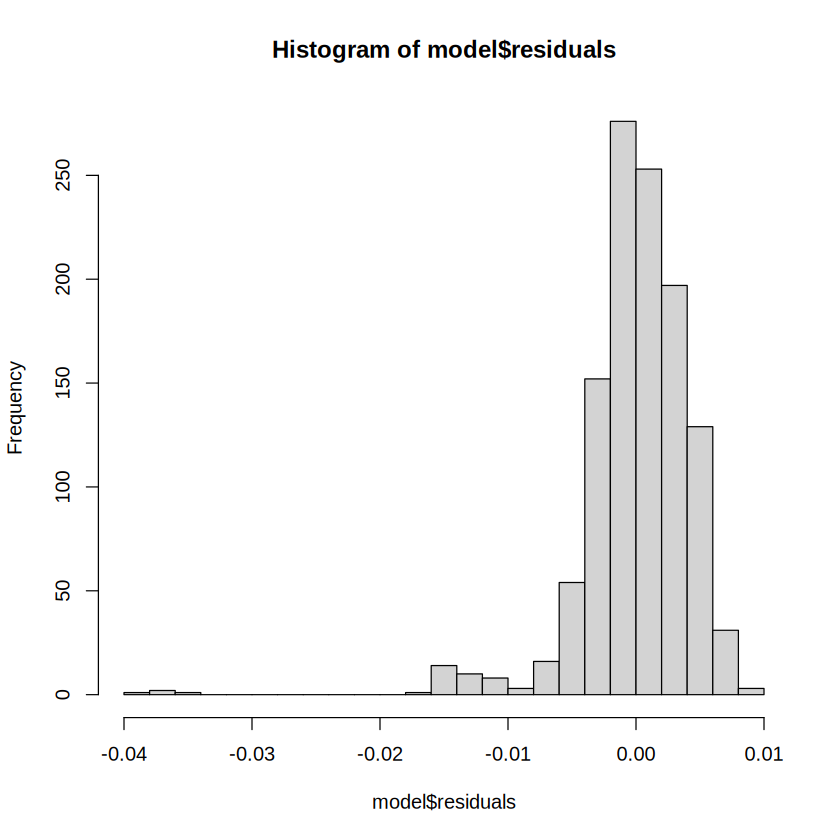

In [55]:
CheckNormal(model = best_model_wqr)

Như vậy, biến thặng dư không có phân phối chuẩn. Như vậy, các phân tích về sau có thể chưa đủ độ tin cậy. Cần có những biến đổi để cải thiện kết quả phân tích.

#### Phân tích Scale-Location

Biểu đồ scale-location kiểm định giả định hồi quy về phương sai bằng nhau (homoscedasticity), tức là giá trị thặng dư có phương sai bằng với đường hồi quy.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic


	studentized Breusch-Pagan test

data:  model
BP = 15.396, df = 5, p-value = 0.008798

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


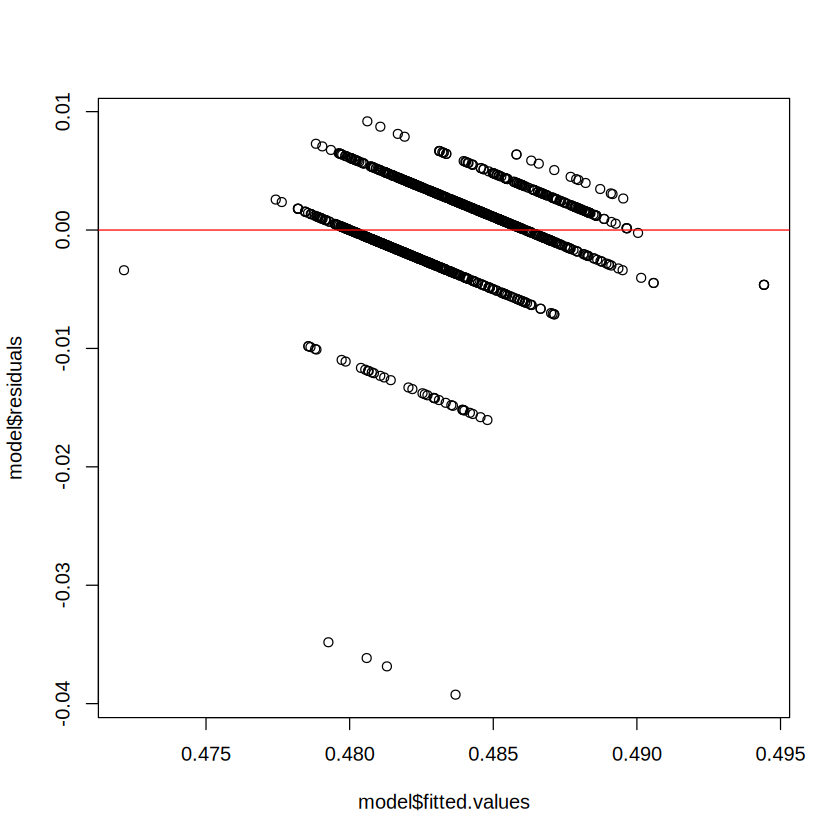

In [56]:
CheckHomos(best_model_wqr)

Như vậy, ta thấy p-value nhỏ hơn múc ý nghĩa 0.05, ta chưa đủ điều kiện bác bỏ H0. Vậy các giá trị thặng dư là heteroscedastic

### Loại bỏ các ngoại lai dựa trên Cook's Distance

In [57]:
# Xây dựng ngưỡng cho Cook Distance
threshold <- 4 / nrow(train)
threshold

[1] 0.003475239


Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0145047 -0.0020579 -0.0002007  0.0024057  0.0081488 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -3.675e-01  6.452e-02  -5.697 1.57e-08 ***
volatile.acidity -2.588e-04  4.493e-05  -5.760 1.09e-08 ***
density          -1.598e-01  6.392e-02  -2.501 0.012541 *  
pH               -9.027e-02  2.437e-02  -3.705 0.000222 ***
sulphates         2.152e-03  2.130e-04  10.105  < 2e-16 ***
alcohol           1.804e+00  1.281e-01  14.081  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.00305 on 1095 degrees of freedom
Multiple R-squared:  0.3961,	Adjusted R-squared:  0.3933 
F-statistic: 143.6 on 5 and 1095 DF,  p-value: < 2.2e-16



	Shapiro-Wilk normality test

data:  model$residuals
W = 0.98082, p-value = 6.991e-11

[1] "H0 rejected: the residuals are NOT distributed normally"


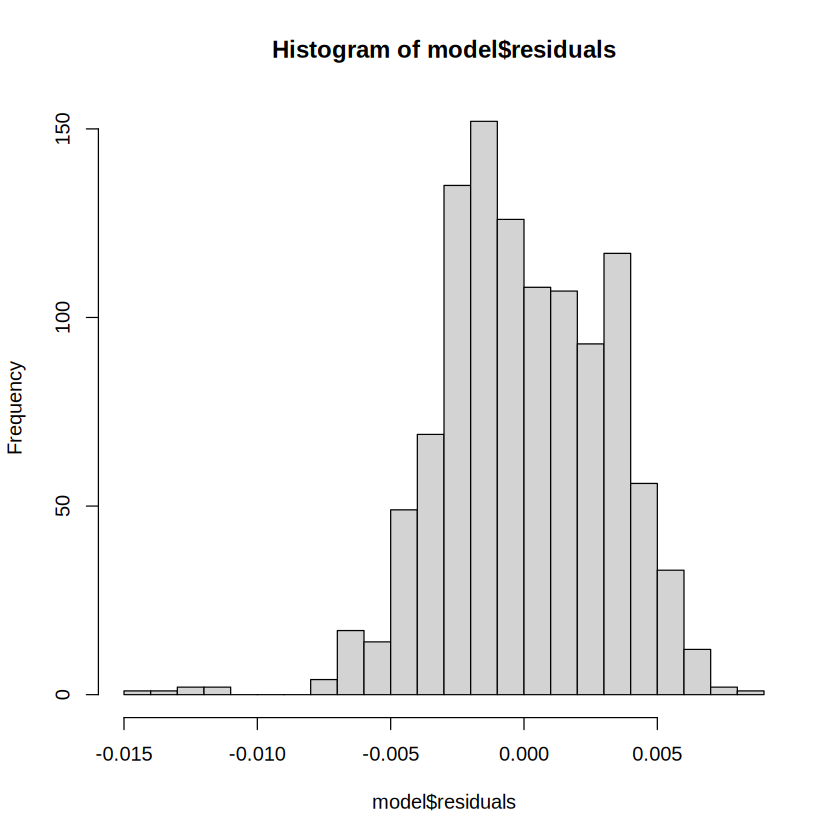


	studentized Breusch-Pagan test

data:  model
BP = 8.2365, df = 5, p-value = 0.1437

[1] "H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)"


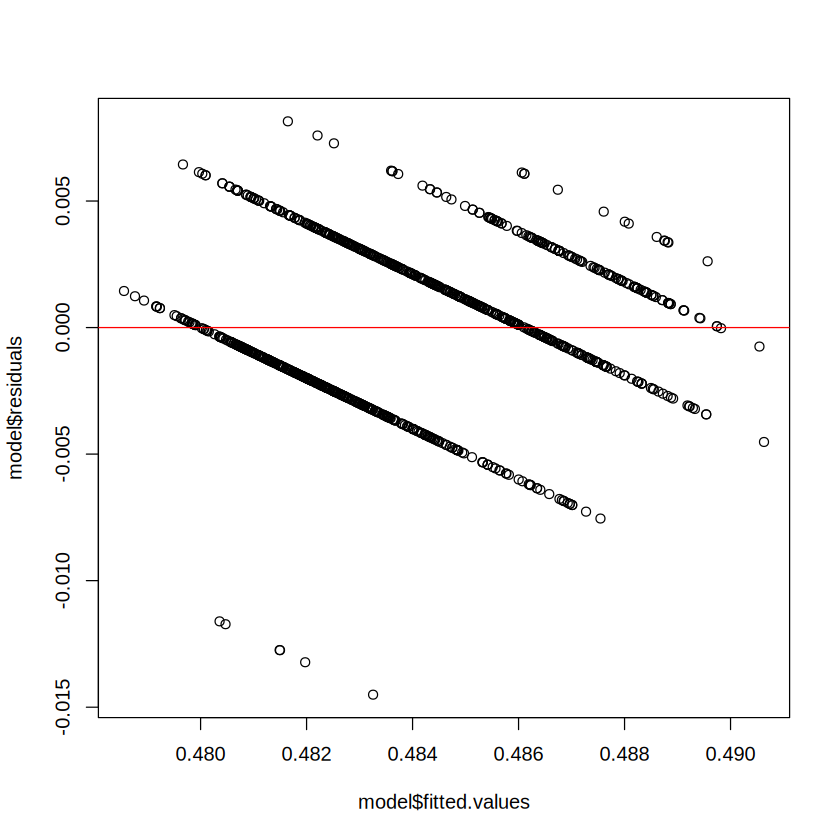

In [58]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_wqr)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_wqr.2 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_wqr.2)

# Shapiro-Wilk normality test
# shapiro.test(residuals(best_model_wqr.2))
CheckNormal(best_model_wqr.2)

# Breusch-Pagan Test
# bptest(best_model_wqr.2)
CheckHomos(best_model_wqr.2)



Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.039178 -0.001780  0.000237  0.002811  0.009203 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -2.962e-01  9.211e-02  -3.216 0.001338 ** 
volatile.acidity -2.442e-04  4.979e-05  -4.904 1.08e-06 ***
density          -2.953e-01  8.916e-02  -3.311 0.000958 ***
pH               -1.631e-01  3.394e-02  -4.805 1.76e-06 ***
sulphates         2.476e-03  2.884e-04   8.586  < 2e-16 ***
alcohol           1.725e+00  1.830e-01   9.426  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.00443 on 1100 degrees of freedom
Multiple R-squared:  0.2732,	Adjusted R-squared:  0.2699 
F-statistic: 82.69 on 5 and 1100 DF,  p-value: < 2.2e-16



	Shapiro-Wilk normality test

data:  model$residuals
W = 0.81417, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


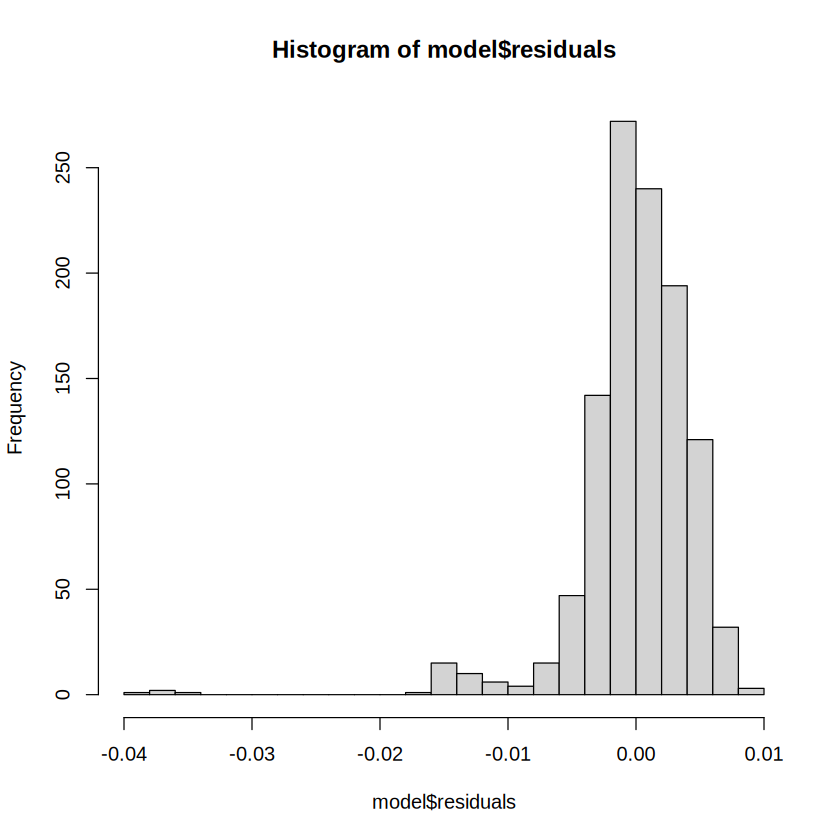


	studentized Breusch-Pagan test

data:  model
BP = 16.202, df = 5, p-value = 0.00629

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


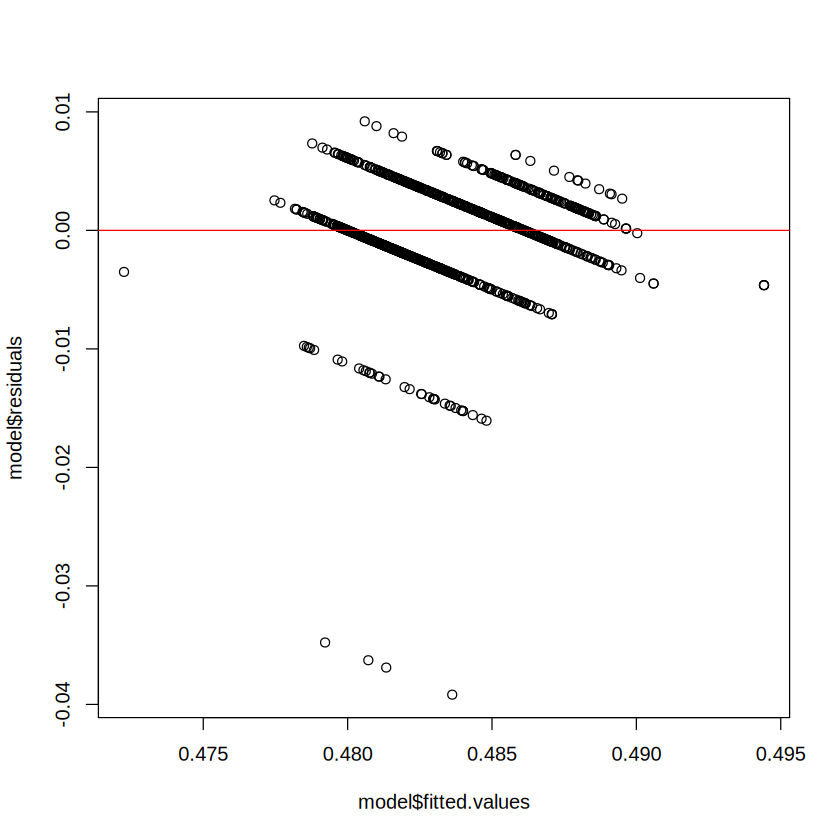

In [59]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_wqr.2)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_wqr.3 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_wqr.3)

# Shapiro-Wilk normality test
CheckNormal(best_model_wqr.3)

# Breusch-Pagan Test
CheckHomos(best_model_wqr.3)

## Đánh giá hiệu suất và dự đoán kết quả

[1] "MSE: 2.6e-05"
[1] "RMSE: 0.005062"
[1] "MAE: 0.003118"
[1] "Correlation: 0.464513"
[1] "R^2 between y_pred & y_true: 0.215773"


[1] 0.005062124

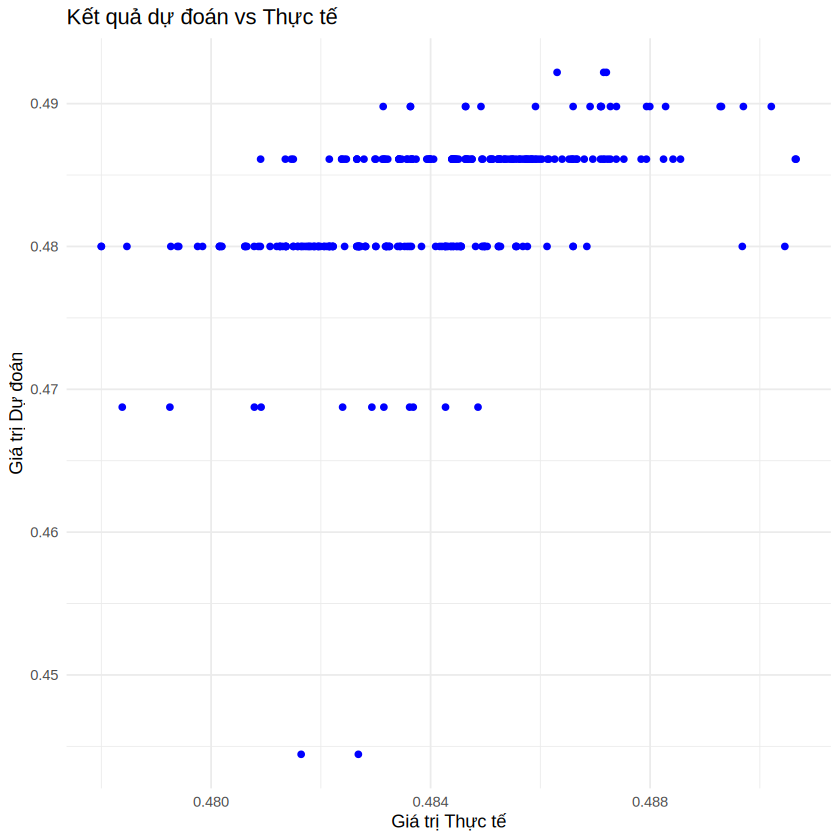

In [60]:
# Dự đoán, tính toán RMSE, và trực quan kết quả dự đoán
results <- predict(best_model_wqr.2, test)
df <- data.frame(
    du_doan <- results,
    label <- test$quality
)

metrics(results, test$quality)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$quality)

In [61]:
print(best_model_wqr.2)


Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Coefficients:
     (Intercept)  volatile.acidity           density                pH  
      -0.3675126        -0.0002588        -0.1598464        -0.0902720  
       sulphates           alcohol  
       0.0021522         1.8035125  



## Kết luận

Dựa trên quá trình mô hình hóa, ta thu được mô hình

```
quality = volatile.acidity + density + pH + sulphates + alcohol
```

với các hệ số:

```
Coefficients:
     (Intercept)  volatile.acidity           density                pH  
      -0.3675126        -0.0002588        -0.1598464        -0.0902720  
       sulphates           alcohol  
       0.0021522         1.8035125 
```

Điều này có nghĩa là:
- Chất lượng rượu phụ thuộc vào nồng độ cồn, nồng độ cồn càng cao, chất lượng rượu càng tăng
- Các chỉ số về tính chua, mật độ rượu, độ pH khiến chất lượng giảm.
